# Macroeconomic Forecasting: Global Liquidity, US Growth, and US Inflation

This notebook builds a comprehensive framework for forecasting three critical macroeconomic indicators:
1.  **Global Liquidity**: A measure of the availability of credit and capital in the global financial system.
2.  **US Economic Growth**: The rate of increase in the production of goods and services in the U.S. economy.
3.  **US Inflation**: The rate at which the general level of prices for goods and services is rising, and subsequently, purchasing power is falling.

We will use a variety of data sources, including the Federal Reserve Economic Data (FRED), to build a Vector Autoregression (VAR) model. This model will capture the complex interdependencies between these variables and provide a forward-looking view.

## 1. Setup and Data Acquisition

First, we install and import the necessary libraries. We will primarily use `pandas_datareader` to fetch data directly from the FRED database.

In [1]:
# Install necessary libraries
!pip install pandas_datareader statsmodels

import pandas as pd
import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
import numpy as np

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (15, 8)

c:\Users\saris\anaconda3\envs\quant\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


### Define FRED Tickers

We will pull data for the following indicators. These have been selected to provide a comprehensive view of our target variables.

*   **Global Liquidity Indicators**:
    *   `WALCL`: Total Assets of the Federal Reserve (Proxy for US Liquidity)
    *   `ECBASSETSW`: Total Assets of the European Central Bank
    *   `JPNASSETS`: Total Assets of the Bank of Japan
    *   `BAMLH0A0HYM2`: BofA US High Yield Index Option-Adjusted Spread (Financial Stress)

*   **US Growth Indicators**:
    *   `GDPC1`: Real Gross Domestic Product (Quarterly, will be resampled)
    *   `INDPRO`: Industrial Production Index
    *   `PAYEMS`: Total Non-Farm Payrolls
    *   `UNRATE`: Civilian Unemployment Rate

*   **US Inflation Indicators**:
    *   `CPIAUCSL`: Consumer Price Index for All Urban Consumers
    *   `PPIACO`: Producer Price Index for All Commodities
    *   `PCEPI`: Personal Consumption Expenditures Price Index
    *   `MICH`: University of Michigan: Inflation Expectation

In [2]:
# Define time period
start = datetime(2003, 1, 1) # Start later to ensure better data coverage
end = datetime.today()

# Define FRED tickers for each component
liquidity_tickers = {
    'FED_ASSETS': 'WALCL',
    'ECB_ASSETS': 'ECBASSETSW',
    'BOJ_ASSETS': 'JPNASSETS',
    'HY_SPREAD': 'BAMLH0A0HYM2',
}
growth_tickers = {
    'REAL_GDP': 'GDPC1',
    'IND_PROD': 'INDPRO',
    'PAYROLLS': 'PAYEMS',
    'UNEMPLOYMENT': 'UNRATE',
}
inflation_tickers = {
    'CPI': 'CPIAUCSL',
    'PPI': 'PPIACO',
    'PCE': 'PCEPI',
    'INFL_EXPECT': 'MICH'
}

def process_component(tickers, start_date, end_date):
    """Downloads, processes, and cleans data for a single macroeconomic component."""
    df_raw = web.DataReader(list(tickers.values()), 'fred', start_date, end_date)
    df_raw.columns = list(tickers.keys())
    df_monthly = df_raw.resample('M').ffill()
    
    df_proc = pd.DataFrame(index=df_monthly.index)
    for col in df_monthly.columns:
        if col not in ['HY_SPREAD', 'UNEMPLOYMENT', 'INFL_EXPECT']:
            df_proc[f'{col}_yoy'] = df_monthly[col].pct_change(12) * 100
        else:
            df_proc[col] = df_monthly[col]
            
    return df_proc.dropna()

# Process each component separately
df_liquidity = process_component(liquidity_tickers, start, end)
df_growth = process_component(growth_tickers, start, end)
df_inflation = process_component(inflation_tickers, start, end)

display(df_liquidity.head())
display(df_growth.head())
display(df_inflation.head())
# Combine the processed components into a single DataFrame
df_yoy = pd.concat([df_liquidity, df_growth, df_inflation], axis=1)

# Forward-fill to handle misaligned start dates from separate processing, then drop any remaining NaNs
df_yoy.ffill(inplace=True)
df_yoy.dropna(inplace=True)

print("Data downloaded and processed by component. Final combined DataFrame head:")
display(df_yoy.head())
# print(f"\nFinal data ranges from {df_yoy.index.min().strftime('%Y-%m-%d')} to {df_yoy.index.max().strftime('%Y-%m-%d')}")

C:\Users\saris\AppData\Local\Temp\ipykernel_31176\91806748.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_raw.resample('M').ffill()
C:\Users\saris\AppData\Local\Temp\ipykernel_31176\91806748.py:34: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_proc[f'{col}_yoy'] = df_monthly[col].pct_change(12) * 100
C:\Users\saris\AppData\Local\Temp\ipykernel_31176\91806748.py:34: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_proc[f'{col}_yoy'] = df_monthly[col].pct_change(12) * 100
C:\Users\saris\AppData\Local\Temp\ipykernel_311

,FED_ASSETS_yoy,ECB_ASSETS_yoy,BOJ_ASSETS_yoy,HY_SPREAD
DATE,,,,


,REAL_GDP_yoy,IND_PROD_yoy,PAYROLLS_yoy,UNEMPLOYMENT
DATE,,,,
2004-01-31,4.341952,1.305618,0.140151,5.7
2004-02-29,4.341952,1.807113,0.290553,5.6
2004-03-31,4.341952,1.688121,0.694130,5.8
2004-04-30,4.227491,2.725390,0.952586,5.6
2004-05-31,4.227491,3.522677,1.152877,5.6


,CPI_yoy,PPI_yoy,PCE_yoy,INFL_EXPECT
DATE,,,,
2004-01-31,2.026287,4.508500,2.212407,2.7
2004-02-29,1.688453,3.270349,2.000619,2.6
2004-03-31,1.740076,1.345609,1.896430,2.9
2004-04-30,2.292576,5.847953,2.259224,3.2
2004-05-31,2.897758,7.388442,2.709538,3.3


Data downloaded and processed by component. Final combined DataFrame head:


,FED_ASSETS_yoy,ECB_ASSETS_yoy,BOJ_ASSETS_yoy,HY_SPREAD,REAL_GDP_yoy,IND_PROD_yoy,PAYROLLS_yoy,UNEMPLOYMENT,CPI_yoy,PPI_yoy,PCE_yoy,INFL_EXPECT
DATE,,,,,,,,,,,,


## 2. Data Exploration and Visualization

Let's visualize the key time series to understand their behavior and relationships.

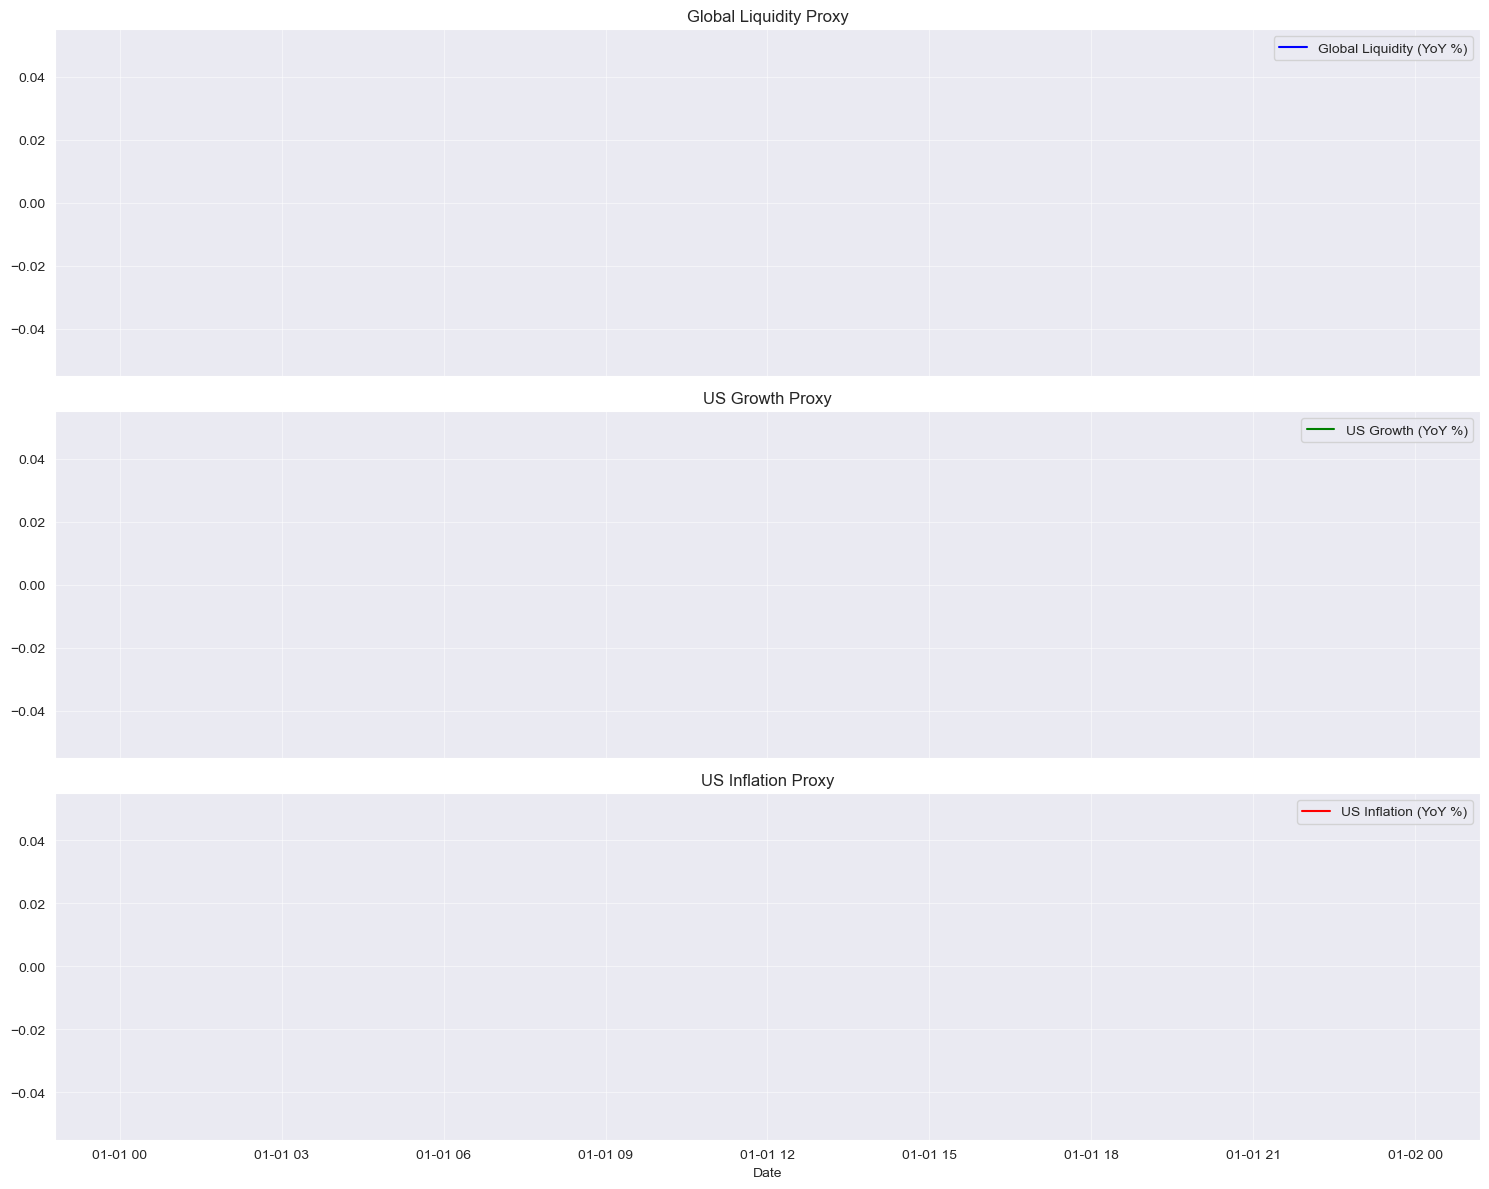

In [3]:
# Create composite indicators for visualization
df_yoy['GLOBAL_LIQUIDITY'] = df_yoy[['FED_ASSETS_yoy', 'ECB_ASSETS_yoy', 'BOJ_ASSETS_yoy']].mean(axis=1)
df_yoy['US_GROWTH'] = df_yoy[['REAL_GDP_yoy', 'IND_PROD_yoy', 'PAYROLLS_yoy']].mean(axis=1)
df_yoy['US_INFLATION'] = df_yoy[['CPI_yoy', 'PPI_yoy', 'PCE_yoy']].mean(axis=1)

# Plot the three main composite indicators
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Global Liquidity
axes[0].plot(df_yoy.index, df_yoy['GLOBAL_LIQUIDITY'], label='Global Liquidity (YoY %)', color='blue')
axes[0].set_title('Global Liquidity Proxy')
axes[0].legend()
axes[0].grid(True, alpha=0.5)

# US Growth
axes[1].plot(df_yoy.index, df_yoy['US_GROWTH'], label='US Growth (YoY %)', color='green')
axes[1].set_title('US Growth Proxy')
axes[1].legend()
axes[1].grid(True, alpha=0.5)

# US Inflation
axes[2].plot(df_yoy.index, df_yoy['US_INFLATION'], label='US Inflation (YoY %)', color='red')
axes[2].set_title('US Inflation Proxy')
axes[2].legend()
axes[2].grid(True, alpha=0.5)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

## 3. Forecasting with Vector Autoregression (VAR)

A VAR model is a multivariate forecasting algorithm that is used when two or more time series influence each other. It captures the linear interdependencies among multiple time series.

We will use our three composite indicators as the inputs to the model.

In [4]:
# Select the data for the model
model_data = df_yoy[['GLOBAL_LIQUIDITY', 'US_GROWTH', 'US_INFLATION']].dropna()

# Fit the VAR model
# A common practice is to select the lag order using an information criterion (e.g., AIC)
# For simplicity, we'll use a fixed number of lags.
model = VAR(model_data)
results = model.fit(4) # Fit with 4 lags

# Print model summary
print(results.summary())

ValueError: zero-size array to reduction operation maximum which has no identity

## 4. Generate and Visualize Forecasts

Now, we use the fitted model to generate forecasts for the next 24 months and visualize the results.

In [ ]:
# Generate forecasts
n_forecast = 24
forecast = results.forecast(model_data.values[-results.k_ar:], steps=n_forecast)

# Create a date range for the forecast
forecast_index = pd.date_range(start=model_data.index[-1], periods=n_forecast + 1, freq='M')[1:]

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=model_data.columns + '_forecast')

# Plot the historical data and the forecast
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

for i, col in enumerate(model_data.columns):
    ax = axes[i]
    model_data[col].plot(ax=ax, label='Historical', color='black')
    forecast_df[col + '_forecast'].plot(ax=ax, label='Forecast', linestyle='--', color='red')
    ax.set_title(f'Forecast for {col}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

print("Forecast for the next 24 months:")
print(forecast_df)

## 5. Conclusion and Next Steps

This notebook provides a foundational framework for macroeconomic forecasting using a VAR model. We successfully loaded data, created composite indicators, and generated forecasts for global liquidity, US growth, and US inflation.

### Future Enhancements:
*   **More Sophisticated Models**: Implement more advanced models like Vector Error Correction Models (VECM) for cointegrated series, or machine learning models like LSTMs or Transformers for potentially capturing non-linear relationships.
*   **Feature Engineering**: Incorporate a wider range of indicators, including sentiment data, commodity prices, or alternative data.
*   **Scenario Analysis**: Use the model to simulate the impact of different economic shocks (e.g., a change in Fed policy).
*   **Richer Evaluation**: Implement more rigorous backtesting and performance evaluation metrics.

## 6. Bond Market Analysis

We analyze the bond market by examining key yield curves and credit spreads:
- **10-Year Treasury Yield**: General interest rate expectations.
- **10Y–2Y Spread**: Indicator of yield curve slope and recession risk.
- **Corporate Bond Spreads (AAA vs BAA)**: Credit conditions and risk premia.

In [ ]:
# 6.1 Fetch and process bond market data
bond_tickers = {
    'US_10Y': 'GS10',            # 10-Year Treasury Yield
    'T10Y2Y': 'T10Y2Y',          # 10-Year minus 2-Year Treasury Spread
    'AAA_YIELD': 'AAA',          # Moody's Aaa Corporate Bond Yield
    'BAA_YIELD': 'BAA'           # Moody's Baa Corporate Bond Yield
}
df_bond = web.DataReader(list(bond_tickers.values()), 'fred', start, end)
df_bond.columns = list(bond_tickers.keys())
# Resample monthly and forward-fill missing
df_bond = df_bond.resample('M').ffill().dropna()
# Compute corporate bond spread
df_bond['CORP_SPREAD'] = df_bond['BAA_YIELD'] - df_bond['AAA_YIELD']

# 6.2 Plot yields and spreads
plt.figure(figsize=(15,10))
ax1 = plt.subplot(2,1,1)
df_bond[['US_10Y']].plot(ax=ax1, color='blue')
df_bond['T10Y2Y'].plot(ax=ax1, color='green')
ax1.set_title('Treasury Yields & Yield Curve Slope')
ax1.set_ylabel('Percent')
ax1.legend(['10Y Yield','10Y-2Y Spread'])
ax1.grid(True)

ax2 = plt.subplot(2,1,2)
df_bond[['AAA_YIELD','BAA_YIELD']].plot(ax=ax2)
df_bond['CORP_SPREAD'].plot(ax=ax2, linestyle='--', color='red')
ax2.set_title('Corporate Bond Yields & AAA-BAA Spread')
ax2.set_ylabel('Percent')
ax2.legend(['AAA Yield','BAA Yield','Credit Spread'])
ax2.grid(True)

plt.tight_layout()
plt.show()

# Display recent bond market snapshot
display(df_bond.tail())